In [12]:
from mkit.torch_support.model.GNN import GNNRegressionWithSkipConnections
from mkit.torch_support.tensor_utils import graph_x_y_split
from mkit.torch_support.nn_utils import training_loop
import torch
from torch import  nn
from tqdm import  tqdm
import matplotlib.pyplot as plt
import networkx as nx
from sklearn.metrics import accuracy_score
from torch_geometric.data import Data
from torch.utils.data import DataLoader
from mkit.torch_support.tensor_utils import MaskedGraphDataset


- Artificial Dataset Generation

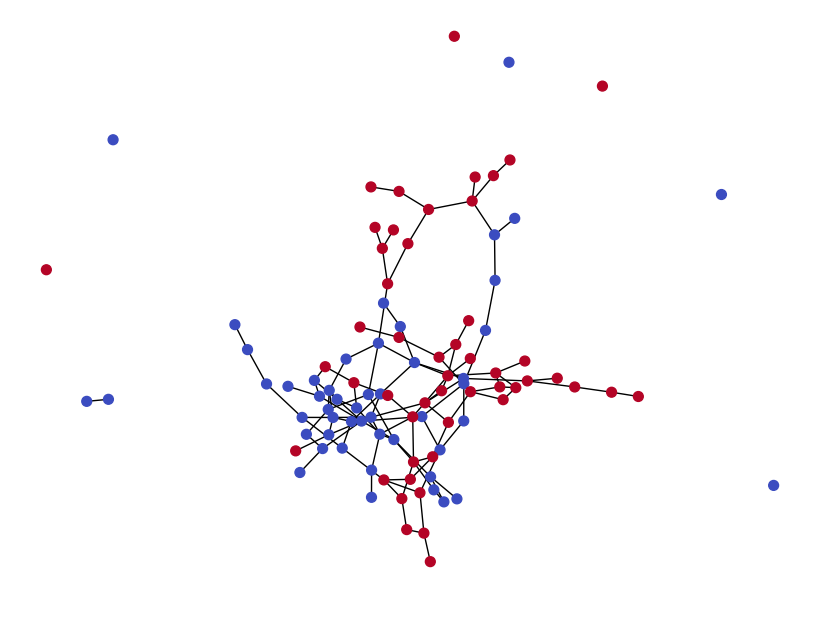

In [13]:

# Parameters
num_nodes = 1000
p_intra = 0.05  # Probability of intra-community edges
p_inter = 0.005  # Probability of inter-community edges

# Create a stochastic block model graph
sizes = [50, 50]  # Two communities of 50 nodes each
probs = [[p_intra, p_inter],
         [p_inter, p_intra]]
G = nx.stochastic_block_model(sizes, probs, seed=42)

# Draw the graph
pos = nx.spring_layout(G, seed=42)
plt.figure(figsize=(8, 6))
nx.draw(G, pos, node_color=[0]*50 + [1]*50, cmap=plt.get_cmap('coolwarm'), node_size=50)
plt.show()

# Get edge list
edge_index = torch.tensor(list(G.edges()), dtype=torch.long).t().contiguous()

# Since the graph is undirected, add both directions
edge_index = torch.cat([edge_index, edge_index[[1, 0], :]], dim=1)


In [14]:
# Assign features based on community
# Community 0: [1, 0], Community 1: [0, 1]
features = []
for node in G.nodes():
    if node < 50:
        features.append([1, 0])
    else:
        features.append([0, 1])
features = torch.tensor(features, dtype=torch.float)
labels = torch.tensor([0]*50 + [1]*50, dtype=torch.long)


- parse index

In [15]:
# Get edge list
edge_index = torch.tensor(list(G.edges()), dtype=torch.long).t().contiguous()

# Since the graph is undirected, add both directions
edge_index = torch.cat([edge_index, edge_index[[1, 0], :]], dim=1)


- split data

In [16]:

data = Data(x=features, edge_index=edge_index, y=labels)
data = graph_x_y_split(data)


train_dataset = MaskedGraphDataset(data, mask_type='train')
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)


- training loop

In [17]:
EPOCHS = 20
# Initialize the model, optimizer, and criterion
model = GNNRegressionWithSkipConnections(2, 16, 2, 2)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()  # Ensure this matches your task

# Training loop
for epoch in tqdm(range(EPOCHS)):
    model.train()
    for batch_x, batch_y, _ in train_loader:  # Node features, labels, and original indices
        optimizer.zero_grad()
        out = model(data)  # Forward pass on the full graph
        loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute loss on train nodes
        loss.backward()
        optimizer.step()

    if epoch % 20 == 0:
        model.eval()
        with torch.no_grad():
            val_loss = criterion(out[data.val_mask], data.y[data.val_mask])
        print(f'Epoch {epoch}, Training Loss: {loss.item():.6f}, Validation Loss: {val_loss.item():.6f}')


  0%|          | 0/20 [00:00<?, ?it/s]

 25%|██▌       | 5/20 [00:00<00:00, 44.52it/s]

Epoch 0, Training Loss: 0.661781, Validation Loss: 0.667163


100%|██████████| 20/20 [00:00<00:00, 44.63it/s]


- prediction

In [18]:

# After training, evaluate on the test set
model.eval()
with torch.no_grad():
    test_out = model(data)
    test_pred = test_out[data.test_mask]
    test_true = data.y[data.test_mask]

- evaluation

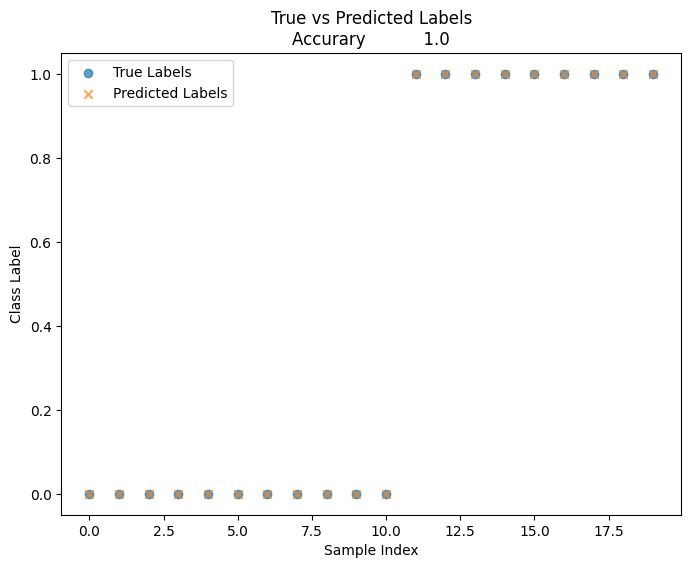

In [19]:


# Convert predictions to probabilities and predicted classes if needed (for classification)
predicted_classes = torch.argmax(test_pred, dim=1)  # Use softmax for probabilities if needed

# Plot predictions vs true labels (for classification)
plt.figure(figsize=(8, 6))

plt.scatter(range(len(test_true)), test_true.cpu(), label='True Labels', alpha=0.7)
plt.scatter(range(len(predicted_classes)), predicted_classes.cpu(), label='Predicted Labels', alpha=0.7, marker='x')
plt.title(f"True vs Predicted Labels\nAccurary \
          {accuracy_score(test_true.cpu(), predicted_classes.cpu())}")
plt.xlabel("Sample Index")
plt.ylabel("Class Label")
plt.legend()
plt.show()
